In [4]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report 


from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img , img_to_array 
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2 
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model


from imutils import paths
import os 


In [ ]:
## Load Dataset
directory = r"D:\dataset"
categories = ['with_mask' , 'without_mask']
data = [] 
target = []
for category in categories : 
    path = os.path.join(directory , category)
   
    for img in os.listdir(path):
        img_path = os.path.join(path , img)




        image = load_img(img_path , target_size= (224 , 224))





        image = img_to_array(image)



        image = preprocess_input(image)


        
        data.append(image)
        target.append(category)

    


d:\Andconda\Lib\site-packages\PIL\Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [21]:
## Binary Encoder to convert ['with_mask' , 'without_mask'] into [0,1]
lb = LabelBinarizer()
target = lb.fit_transform(target) ## return Vector 
target = to_categorical(target) ## convert Vector into Metric
data = np.array(data)
target = np.array(target)
print(data , target)

[[[[-0.46666664 -0.49019605 -0.4352941 ]
   [-0.46666664 -0.49019605 -0.4352941 ]
   [-0.46666664 -0.49019605 -0.4352941 ]
   ...
   [-0.38823527 -0.6392157  -0.7411765 ]
   [-0.38823527 -0.6392157  -0.7411765 ]
   [-0.38823527 -0.6392157  -0.7411765 ]]

  [[-0.46666664 -0.49019605 -0.4352941 ]
   [-0.46666664 -0.49019605 -0.4352941 ]
   [-0.46666664 -0.49019605 -0.4352941 ]
   ...
   [-0.38823527 -0.6392157  -0.7411765 ]
   [-0.38823527 -0.6392157  -0.7411765 ]
   [-0.38823527 -0.6392157  -0.7411765 ]]

  [[-0.3960784  -0.4588235  -0.372549  ]
   [-0.3960784  -0.4588235  -0.372549  ]
   [-0.3960784  -0.4588235  -0.372549  ]
   ...
   [-0.45098037 -0.62352943 -0.8039216 ]
   [-0.45098037 -0.62352943 -0.8039216 ]
   [-0.45098037 -0.62352943 -0.8039216 ]]

  ...

  [[-0.4352941  -0.6862745  -0.8039216 ]
   [-0.4352941  -0.6862745  -0.8039216 ]
   [-0.4352941  -0.6862745  -0.8039216 ]
   ...
   [-0.34117645 -0.52156866 -0.6313726 ]
   [-0.34117645 -0.52156866 -0.6313726 ]
   [-0.34117645 

In [7]:
## split the data --> train- test
x_train , x_test , y_train , y_test = train_test_split(data , target , test_size= 0.2 , stratify=target , random_state=42)

In [8]:
## func to generate new data images 
aug = ImageDataGenerator(
    rotation_range = 20 , 
    zoom_range = 0.10 , 
    width_shift_range = 0.1 , 
    height_shift_range = 0.1 ,
    shear_range = 0.2 , 
    horizontal_flip=True, 
    fill_mode = 'nearest'

)

In [ ]:
baseModel = MobileNetV2(weights='imagenet' , include_top=False ,input_tensor=Input(shape=(224,224,3))) 

head_model = baseModel.output ## this is the last layer in base Model 
head_model = MaxPooling2D(pool_size=(7,7))(head_model) ## MaxPooling and connect it with head_model -> last layer ---< Build related connected layers 
head_model = Flatten()(head_model)
head_model = Dense(128 , activation= 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(2 , activation='softmax')(head_model) ## Output Layer 

model = Model(baseModel.input , outputs = head_model )

C:\Users\elmoa\AppData\Local\Temp\ipykernel_10268\2987371508.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  baseModel = MobileNetV2(weights='imagenet' , include_top=False ,input_tensor=Input(shape=(224,224,3))) ## Mobile net V2 takes this shape


In [10]:
## here we turn off all layers to never update the weight and reduce train time *-- we want only the pretrained weights 
for layer in baseModel.layers : 
    layer.trainable = False  

In [ ]:
## Compile Our Model 

opt = Adam(learning_rate = 0.001)
model.compile(optimizer=opt , loss = 'binary_crossentropy' , metrics=['accuracy'])

train_generator =  aug.flow(x_train , y_train , batch_size= 32) 

M = model.fit(
    train_generator , 
    epochs=10 ,
    validation_data = (x_test , y_test)
)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 50s 480ms/step - accuracy: 0.9198 - loss: 0.3512 - val_accuracy: 0.9765 - val_loss: 0.0590
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 44s 460ms/step - accuracy: 0.9746 - loss: 0.0684 - val_accuracy: 0.9857 - val_loss: 0.0491
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 46s 482ms/step - accuracy: 0.9808 - loss: 0.0599 - val_accuracy: 0.9870 - val_loss: 0.0430
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 44s 459ms/step - accuracy: 0.9801 - loss: 0.0571 - val_accuracy: 0.9870 - val_loss: 0.0378
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 44s 460ms/step - accuracy: 0.9863 - loss: 0.0496 - val_accuracy: 0.9870 - val_loss: 0.0308
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 45s 467ms/step - accuracy: 0.9863 - loss: 0.0378 - val_accuracy: 0.9817 - val_loss: 0.0599
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 47s 485ms/step - accuracy: 0.9843 - loss: 0.0442 - val_accuracy: 0.9857 - val_loss: 0.0387
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 45s 469ms/step - accuracy: 0.9905 - loss: 0.0311 - val_accu

In [12]:
predicted = model.predict(x_test , batch_size=32)
predicted_max = np.argmax(predicted , axis = 1 )

print(classification_report(y_test.argmax(axis =1) , predicted_max  , target_names= lb.classes_))

24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 282ms/step
              precision    recall  f1-score   support

   with_mask       0.98      0.99      0.99       383
without_mask       0.99      0.98      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



In [13]:
model.save("mask_detector_model.h5")
model.save("mask_detector_model.keras") 


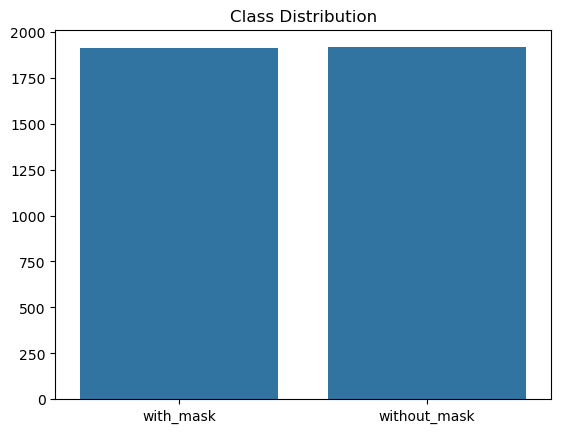

In [14]:

import os
import matplotlib.pyplot as plt
import seaborn as sns

directory = r"D:\dataset"
categories = ['with_mask', 'without_mask']

counts = {c: len(os.listdir(os.path.join(directory, c))) for c in categories}

sns.barplot(x=list(counts.keys()), y=list(counts.values()))
plt.title("Class Distribution")
plt.show()


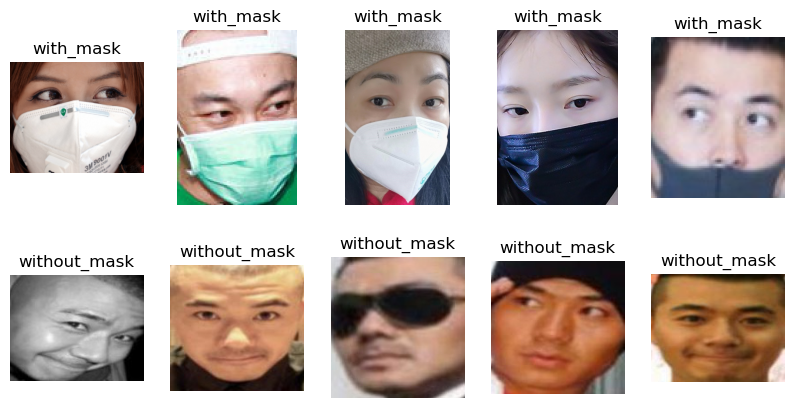

In [15]:
fig, ax = plt.subplots(2, 5, figsize=(10,5))
i = 0
for category in categories:
    path = os.path.join(directory, category)
    for img in os.listdir(path)[20:25]:
        img_path = os.path.join(path, img)
        image = load_img(img_path)
        ax[i//5][i%5].imshow(image)
        ax[i//5][i%5].set_title(category)
        ax[i//5][i%5].axis("off")
        i += 1


In [16]:

data = np.array(data)
print("Dataset Shape:", data.shape)
print("Target Shape:", target.shape)


Dataset Shape: (3833, 224, 224, 3)
Target Shape: (3833, 2)


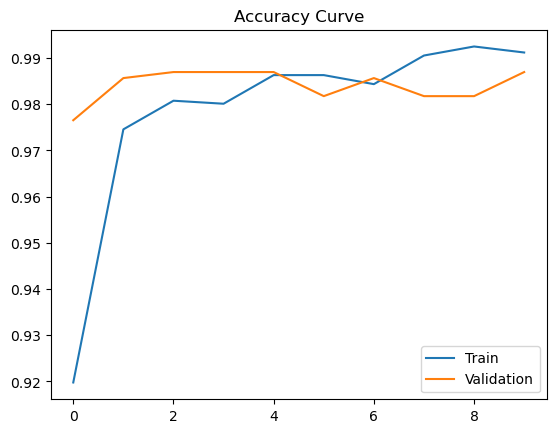

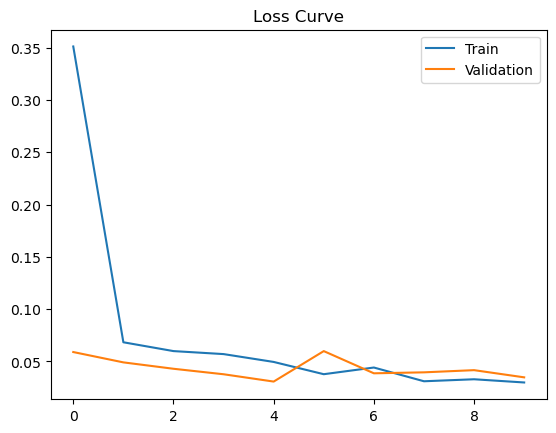

In [17]:
plt.plot(M.history['accuracy'])
plt.plot(M.history['val_accuracy'])
plt.title("Accuracy Curve")
plt.legend(['Train', 'Validation'])
plt.show()

plt.plot(M.history['loss'])
plt.plot(M.history['val_loss'])
plt.title("Loss Curve")
plt.legend(['Train', 'Validation'])
plt.show()


In [18]:
from sklearn.metrics import classification_report

pred = model.predict(x_test)
pred = np.argmax(pred, axis=1)
true = np.argmax(y_test, axis=1)

print(classification_report(true, pred, target_names=categories))


24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 235ms/step
              precision    recall  f1-score   support

   with_mask       0.98      0.99      0.99       383
without_mask       0.99      0.98      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



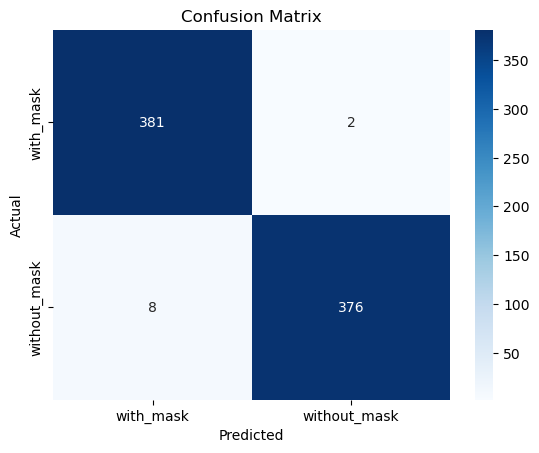

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(true, pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=categories,
            yticklabels=categories)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Inference Time per image: 0.08974790573120117
